In [21]:
from autqec.automorphisms import *
from autqec.ZX_dualities import *
from autqec.utils.qec import *
from autqec.utils.qiskit import *
from autqec.utils.magma import *
import pickle

import numpy as np
from scipy.sparse import csr_matrix
import stim
from ldpc.ckt_noise.css_code_memory_circuit import make_css_code_memory_circuit

## [[72,12,6]] 

#### Define code

In [22]:
n = 72
k = 12
d = 6

H_X = np.load(f'./bivariate_bicycle_codes/code_data/HX_n{n}k{k}d{d}.npy')

H_Z = np.load(f'./bivariate_bicycle_codes/code_data/HZ_n{n}k{k}d{d}.npy')

zeros = np.zeros_like(H_X)
H_symp = np.array(np.vstack((np.hstack((H_X,zeros)),np.hstack((zeros,H_Z)))),dtype=int)

In [23]:
H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
assert H_symp_rref_og_basis.shape[0] == n-k
assert H_symp_rref_og_basis.shape[1] == 2*n

#### Standard form of code

In [24]:
G, LX, LZ, D = compute_standard_form(H_symp_rref_og_basis)

In [25]:
# LX and LZ are in symplectic form. Let's split them up into XL and ZL like the form of H_X and H_Z:
XL = []
ZL = []
for i in range(len(LZ)):
    thisLX = LX[i]
    thisXL = thisLX[:n]
    XL.append(thisXL)

    thisLZ = LZ[i]
    thisZL = thisLZ[n:]
    ZL.append(thisZL)

    if len(thisXL) != n or len(thisZL) != n or len(thisLX) != 2 * n or len(thisLZ) != 2 * n:
        print("length error")
        break


## Syndrome extraction circuit

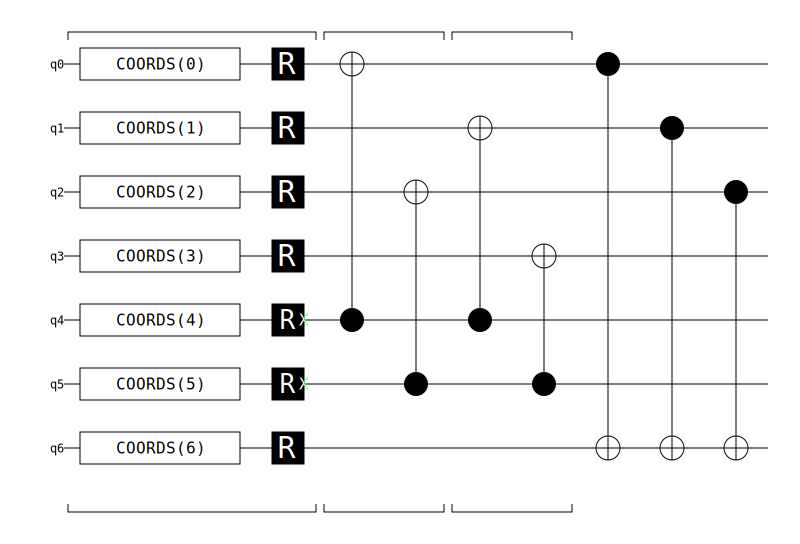

In [28]:
p = 1e-3
circuit = make_css_code_memory_circuit(
    x_stabilizers=H_X,
    z_stabilizers=H_Z,
    x_logicals=XL,
    z_logicals=ZL,
    num_rounds=3,
    basis="Z",  # 
    after_clifford_depolarization = p,
    before_round_data_depolarization = p,
    before_measure_flip_probability = p,
    after_reset_flip_probability = p,
    idle_during_clifford_depolarization = p,
    idle_inactive_measure_qubits_during_clifford_depolarization = p,
    include_opposite_basis_detectors = True, # turn this to False for faster sims    
)

# Afficher le circuit
circuit.without_noise().diagram('timeline-svg', tick = range(0,6)) # comment out tick to see whole circuit; add without_noise() before .diagram to see without noise


In [27]:
# D2 rotated surface code:
H_X = csr_matrix([[1, 1, 0, 0],
                 [0, 0, 1, 1]])
H_Z = csr_matrix([[1, 1, 1, 1]])
XL = csr_matrix([[1, 0, 1, 0]])  
ZL = csr_matrix([[1, 1, 0, 0]])  